# Massive Quiescent Selection in COSMOS-Web

This notebook mirrors the clean-galaxy workflow applied earlier but targets quiescent galaxies with stellar masses above $10^{10}\,M_\odot$.

## Imports and Paths
Set up the Python environment and point to the local COSMOS-Web master catalog.

In [15]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.dpi'] = 150

In [16]:
data_dir = Path('/Users/marchuertascompany/Documents/data/COSMOS-Web/catalogs')
catalog_path = data_dir / 'COSMOSWeb_mastercatalog_v1.fits'

if not catalog_path.exists():
    raise FileNotFoundError(f"Catalog not found at {catalog_path}")

catalog_path

PosixPath('/Users/marchuertascompany/Documents/data/COSMOS-Web/catalogs/COSMOSWeb_mastercatalog_v1.fits')

## Load the Catalog Subsets
Only the columns needed for the selection are read from the photometry (HDU=1) and LePHARE (HDU=2) tables. The HDUs share a common ordering, so we simply verify the IDs match and then append the photometry columns.

In [17]:
photom_cols = ['id', 'warn_flag', 'mag_model_f444w', 'flag_star_hsc']
lephare_cols = ['type', 'zfinal', 'mass_med', 'ssfr_med', 'mabs_nuv', 'mabs_r', 'mabs_j']

cat_photom = Table.read(catalog_path, hdu=1)[photom_cols]
lephare_raw = Table.read(catalog_path, hdu=2)

cat_lephare = lephare_raw[lephare_cols]

catalog = cat_lephare.copy()
for col in photom_cols:
    catalog[col] = cat_photom[col]

catalog

type,zfinal,mass_med,ssfr_med,mabs_nuv,mabs_r,mabs_j,id,warn_flag,mag_model_f444w,flag_star_hsc
int64,float64,float64,float64,float64,float64,float64,int64,int64,float64,int16
0,0.1671,6.86523,-9.80926,-8.81732,-12.01759,-13.21911,0,0,26.8027427460521,0
0,0.9261,8.89948,-7.69984,-18.56224,-20.04946,-21.12883,1,0,22.303638685912937,0
0,1.865,8.04512,-8.5126,-16.38266,-17.70433,-17.73541,2,0,26.89451591521585,0
0,1.6833,9.10093,-7.30187,-19.98842,-20.90562,-21.81576,3,0,22.535185273989143,0
0,0.9253,9.25092,-10.05823,-16.71218,-19.51574,-20.08685,4,0,23.41340105664374,0
0,0.6265,10.37764,-9.45466,-18.89398,-21.87453,-22.67063,5,0,20.142749500759624,0
2,-99.0,8.85463,-7.78017,-21.16034,-20.97432,-20.06965,6,1,27.660035852015586,0
0,2.1607,7.06368,-7.32736,-17.35161,-17.92268,-16.90968,7,0,27.85027196609567,0
0,1.5991,8.28374,-8.56587,-18.09692,-18.45969,-18.31483,8,0,26.014728805904916,0


## Load ML-MORPHO Predictions
Pull in the machine-learning morphology scores (spheroid, disk, bulge+disk, irregular) from the ML-MORPHO extension for the available NIRCam filters.

In [18]:
morph_components = ['sph', 'disk', 'bd', 'irr']
morph_filters = ['f150w', 'f277w', 'f444w']

morph_cols = [f"{comp}_{filt}_mean" for filt in morph_filters for comp in morph_components]
cat_morpho = Table.read(catalog_path, hdu=5)[morph_cols]



for col in morph_cols[0:]:
    values = np.asarray(cat_morpho[col], dtype=float)
    values[values < 0] = np.nan
    catalog[col] = values

full_morph_matrix = np.column_stack([np.asarray(catalog[col], dtype=float) for col in morph_cols[1:]])
has_any_morph = np.isfinite(full_morph_matrix).any(axis=1)
catalog['has_any_morphology'] = has_any_morph

valid_count = int(has_any_morph.sum())
print(f"Morphology scores available for {valid_count:,} sources ({valid_count/len(catalog):.1%}).")

Morphology scores available for 453,554 sources (57.9%).


## Load Local Density Catalog
Integrate the COSMOS-Web local overdensity measurements to enable environment-dependent analyses.

In [19]:
density_path = Path('/Users/marchuertascompany/Documents/data/COSMOS-Web/density/Malte_densityfield.fits')

if not density_path.exists():
    raise FileNotFoundError(f"Density catalog not found at {density_path}")

density_table = Table.read(density_path)
colname_map = {name.lower(): name for name in density_table.colnames}

def get_density_column(*candidates):
    for cand in candidates:
        key = cand.lower()
        if key in colname_map:
            return colname_map[key]
    raise KeyError(f"None of the candidate columns {candidates} found in density table.")

id_col = get_density_column('cosmos2025_id', 'id', 'source_id')
overdensity_col = get_density_column('overdensity', 'delta', 'density')

density_ids = np.asarray(density_table[id_col], dtype=int)
density_values = np.asarray(density_table[overdensity_col], dtype=float)

density_lookup = dict(zip(density_ids, density_values))

catalog_ids = np.asarray(cat_photom['id'], dtype=int)
overdensity_array = np.full(len(catalog_ids), np.nan)

for idx, source_id in enumerate(catalog_ids):
    value = density_lookup.get(int(source_id))
    if value is not None:
        overdensity_array[idx] = value

catalog['overdensity'] = overdensity_array

matched = np.isfinite(overdensity_array).sum()
print(f"Overdensity matched for {matched:,} sources ({matched/len(overdensity_array):.1%}).")

Overdensity matched for 460,099 sources (58.7%).


## Load CIGALE SFH Columns
Bring in the CIGALE non-parametric star-formation histories to enable population averages.

In [20]:
sfh_time_cols = [f'sfh_time_bin{i}' for i in range(1, 10)]
sfh_sfr_cols = [f'sfh_sfr_bin{i}' for i in range(1, 10)]
cigale_cols = ['sfh_integrated'] + sfh_time_cols + sfh_sfr_cols

cat_cigale = Table.read(catalog_path, hdu=4)[cigale_cols]

for col in cigale_cols[0:]:
    catalog[col] = np.asarray(cat_cigale[col], dtype=float)

print('Loaded CIGALE SFH columns.')

Loaded CIGALE SFH columns.


## Build Clean, High-Mass Quiescent Selection
Follow the tutorial recipe for a clean galaxy sample, require morphology coverage in the appropriate filters, and then select quiescent systems with $M_\star>10^{10} M_\odot$.

In [21]:
# Compute rest-frame color combinations
mabs_nuv = np.ma.filled(np.asarray(catalog['mabs_nuv'], dtype=float), np.nan)
mabs_r = np.ma.filled(np.asarray(catalog['mabs_r'], dtype=float), np.nan)
mabs_j = np.ma.filled(np.asarray(catalog['mabs_j'], dtype=float), np.nan)
mass_log = np.ma.filled(np.asarray(catalog['mass_med'], dtype=float), np.nan)
z = np.asarray(catalog['zfinal'], dtype=float)

nuv_minus_r = mabs_nuv - mabs_r
r_minus_j = mabs_r - mabs_j

catalog['nuv_minus_r'] = nuv_minus_r
catalog['r_minus_j'] = r_minus_j

# Clean-galaxy mask from the tutorial
clean_mask = (
    (np.asarray(catalog['type']) == 0) &
    (np.asarray(catalog['warn_flag']) == 0) &
    (np.abs(np.asarray(catalog['mag_model_f444w'])) < 30) &
    (np.asarray(catalog['flag_star_hsc']) == 0)
)

# Require finite colors and masses
finite_mask = (
    np.isfinite(nuv_minus_r) &
    np.isfinite(r_minus_j) &
    np.isfinite(mass_log)
)

clean_mask &= finite_mask

# Require morphology labels in the chosen filter for each redshift regime
scores_f150 = np.column_stack([
    np.asarray(catalog[f'{comp}_f150w_mean'], dtype=float) for comp in morph_components
])
scores_f277 = np.column_stack([
    np.asarray(catalog[f'{comp}_f277w_mean'], dtype=float) for comp in morph_components
])
scores_f444 = np.column_stack([
    np.asarray(catalog[f'{comp}_f444w_mean'], dtype=float) for comp in morph_components
])

valid_f150 = np.isfinite(scores_f150).any(axis=1)
valid_f277 = np.isfinite(scores_f277).any(axis=1)
valid_f444 = np.isfinite(scores_f444).any(axis=1)

primary_morph_mask = (
    ((z < 1.0) & valid_f150) |
    ((z >= 1.0) & (z < 3.0) & valid_f277) |
    ((z >= 3.0) & valid_f444)
)

clean_mask &= primary_morph_mask
catalog['morph_primary_available'] = primary_morph_mask

# Low-mass and quiescent requirements
high_mass_mask = mass_log > 10.0
quiescent_mask = (nuv_minus_r > 3.1) & (nuv_minus_r > 3.0 * r_minus_j + 1.0)

final_mask = clean_mask & high_mass_mask & quiescent_mask

quiescent_sample = catalog[final_mask]
print(f"Total catalog sources        : {len(catalog):,}")
print(f"Clean galaxy sample          : {clean_mask.sum():,}")
print(f"High-mass quiescent selection : {len(quiescent_sample):,}")

Total catalog sources        : 784,016
Clean galaxy sample          : 342,797
High-mass quiescent selection : 4,822


## Assign Morphological Classes
Choose the most appropriate morphology scores per galaxy based on redshift and record both the primary and secondary classifications.

In [22]:
z = np.asarray(catalog['zfinal'], dtype=float)
primary_available = np.asarray(catalog['morph_primary_available'], dtype=bool)

scores_matrix = np.full((len(catalog), 4), np.nan)
filter_used = np.full(len(catalog), 'none', dtype=object)

# Pre-compute score arrays for each filter
scores_per_filter = {}
for filt in morph_filters:
    scores_per_filter[filt] = np.column_stack([
        np.asarray(catalog[f'{comp}_{filt}_mean'], dtype=float) for comp in morph_components
    ])

use_f150 = (z < 1.0) & primary_available
use_f277 = (z >= 1.0) & (z < 3.0) & primary_available
use_f444 = (z >= 3.0) & primary_available

if use_f150.any():
    scores_matrix[use_f150] = scores_per_filter['f150w'][use_f150]
    filter_used[use_f150] = 'f150w'
if use_f277.any():
    scores_matrix[use_f277] = scores_per_filter['f277w'][use_f277]
    filter_used[use_f277] = 'f277w'
if use_f444.any():
    scores_matrix[use_f444] = scores_per_filter['f444w'][use_f444]
    filter_used[use_f444] = 'f444w'

# Prepare for ranking, treating missing values as -inf for sorting
scores_for_sort = np.nan_to_num(scores_matrix, nan=-np.inf)
order = np.argsort(scores_for_sort, axis=1)
main_idx = order[:, -1]
second_idx = order[:, -2]

finite_counts = np.isfinite(scores_matrix).sum(axis=1)
class_labels = np.array(['spheroid', 'disk', 'bulge+disk', 'irregular'])

main_class = np.full(len(catalog), 'unclassified', dtype='<U16')
main_score = np.full(len(catalog), np.nan)
mask_main = finite_counts > 0
main_class[mask_main] = class_labels[main_idx[mask_main]]
main_score[mask_main] = np.take_along_axis(scores_matrix, main_idx[:, None], axis=1)[mask_main, 0]

second_class = np.full(len(catalog), 'none', dtype='<U16')
second_score = np.full(len(catalog), np.nan)
mask_second = finite_counts > 1
second_class[mask_second] = class_labels[second_idx[mask_second]]
second_score[mask_second] = np.take_along_axis(scores_matrix, second_idx[:, None], axis=1)[mask_second, 0]

catalog['morph_filter'] = filter_used
catalog['morph_main_class'] = main_class
catalog['morph_main_score'] = main_score
catalog['morph_second_class'] = second_class
catalog['morph_second_score'] = second_score

unique_class = np.array(main_class, dtype='<U24')
mask_irregular_primary = main_class == 'irregular'
unique_class[mask_irregular_primary] = np.where(
    second_class[mask_irregular_primary] == 'none',
    'irregular',
    np.char.add('irr-', second_class[mask_irregular_primary])
)

catalog['morph_unique_class'] = unique_class

# Refresh the selected sample so the new columns are included
quiescent_sample = catalog[final_mask]

print('Primary morphology counts (all sources with classifications):')
for label in ['spheroid', 'disk', 'bulge+disk', 'irregular']:
    count = np.count_nonzero(main_class == label)
    if count > 0:
        print(f"  {label:12s}: {count:,}")

print('Unique morphology counts within the selected sample:')
unique_labels, unique_counts = np.unique(catalog['morph_unique_class'][final_mask], return_counts=True)
for label, count in zip(unique_labels, unique_counts):
    print(f"  {label:15s}: {count:,}")

Primary morphology counts (all sources with classifications):
  spheroid    : 18,990
  disk        : 26,565
  bulge+disk  : 11,145
  irregular   : 396,854
Unique morphology counts within the selected sample:
  bulge+disk     : 2,491
  disk           : 158
  irr-bulge+disk : 64
  irr-disk       : 92
  irr-spheroid   : 121
  spheroid       : 1,896


## Color–Color Selection by Redshift
Visualise how the $NUV-r$ vs. $r-J$ distribution evolves across redshift bins, highlighting the low-mass quiescent subset with the consolidated morphology class.

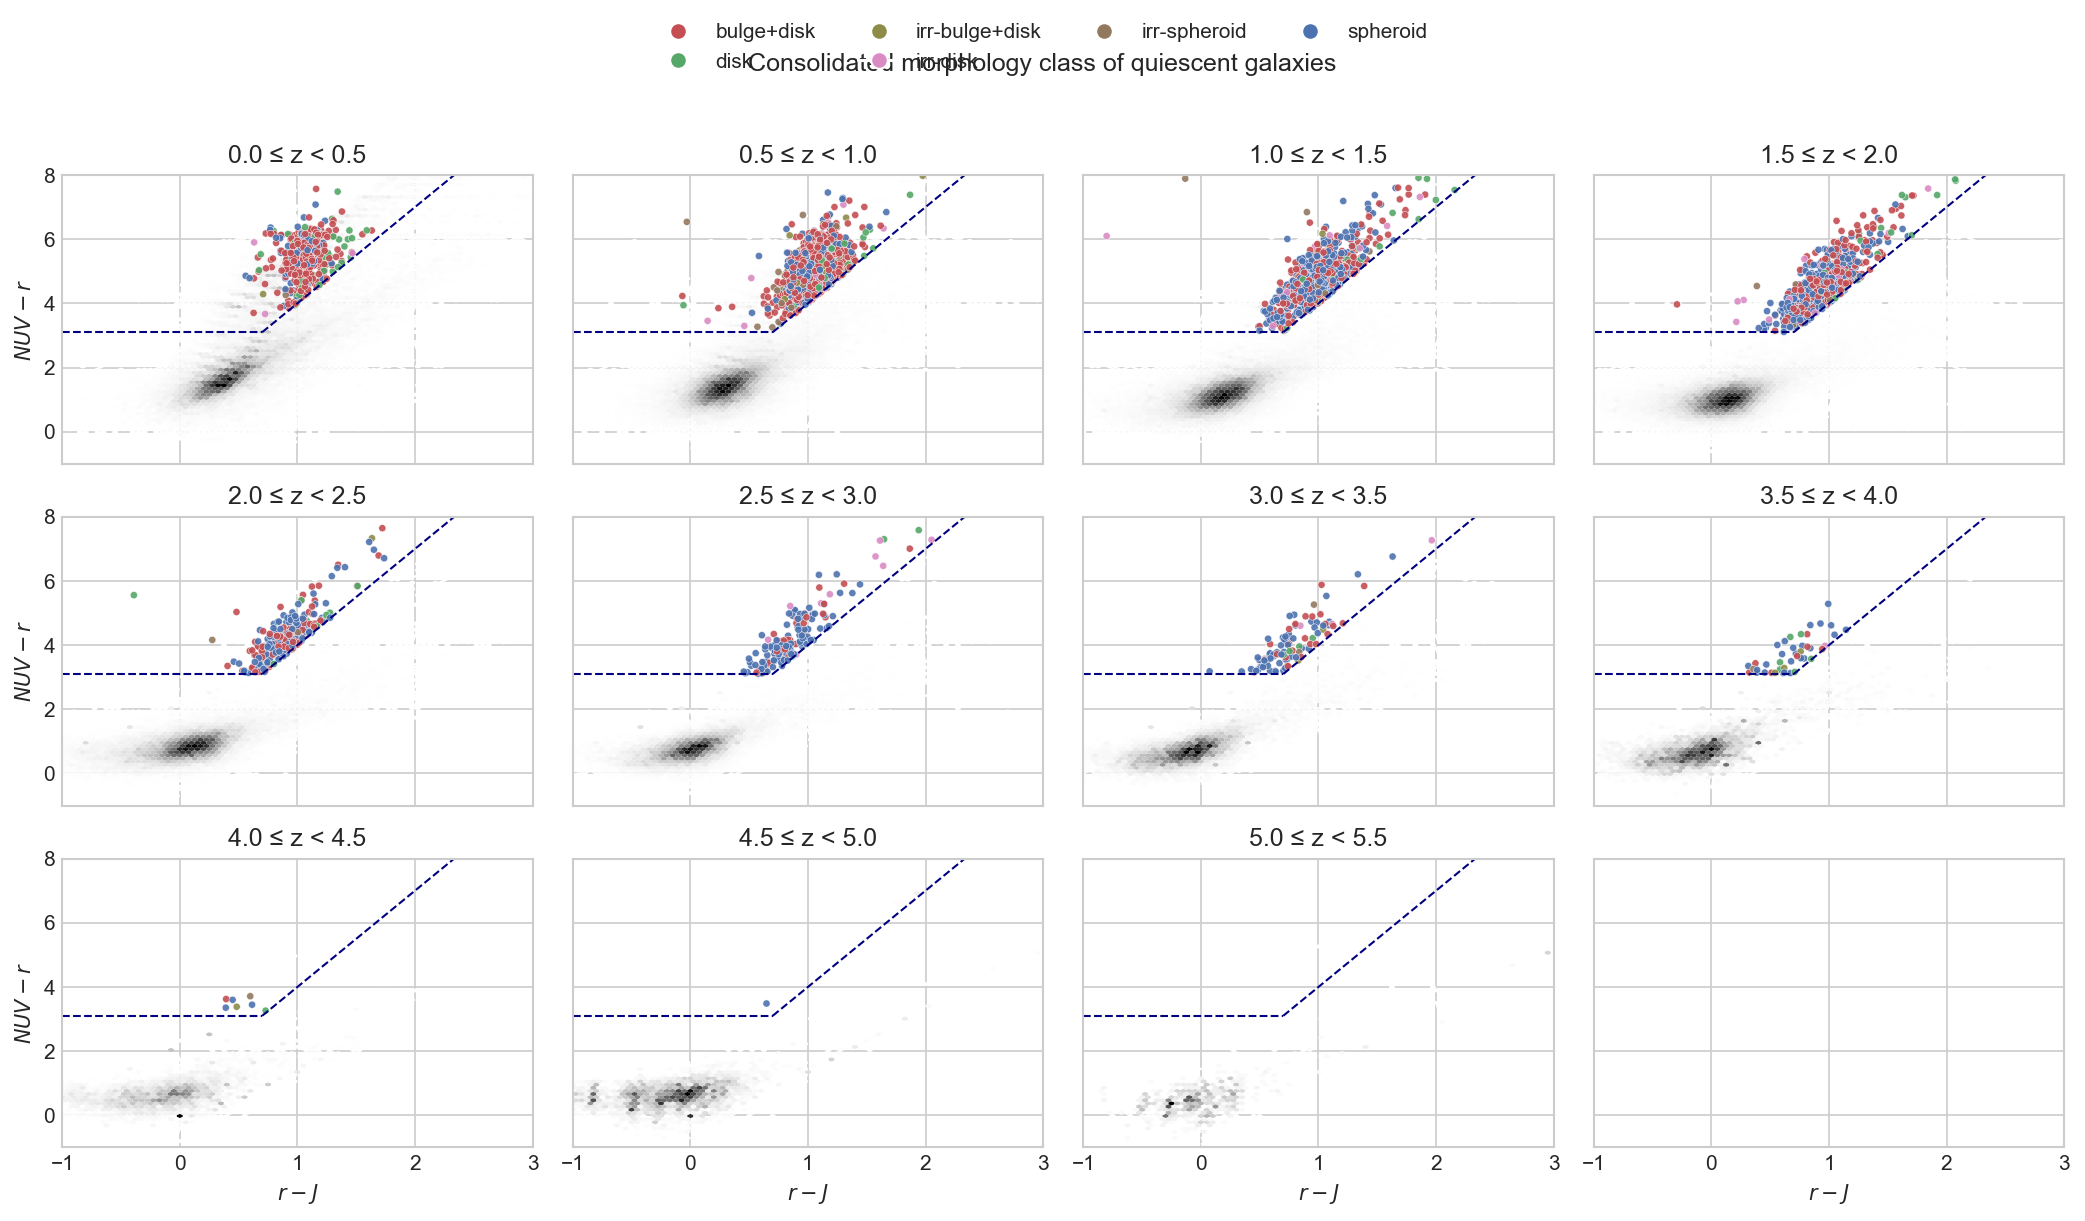

In [23]:
z_bins = np.arange(0.0, 5.6, 0.5)
z_labels = [f"{z_bins[i]:.1f} ≤ z < {z_bins[i+1]:.1f}" for i in range(len(z_bins) - 1)]

# Shared redshift bins defined earlier: z_bins, z_labels
class_palette = {
    'spheroid': '#4C72B0',
    'disk': '#55A868',
    'bulge+disk': '#C44E52',
    'irregular': '#8172B2',
    'irr-spheroid': '#937860',
    'irr-disk': '#DA8BC3',
    'irr-bulge+disk': '#8C8C47'
}

unique_classes_overall = sorted(set(catalog['morph_unique_class'][final_mask]))

fig, axes = plt.subplots(3, 4, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.ravel()

for idx, (z_min, z_max) in enumerate(zip(z_bins[:-1], z_bins[1:])):
    ax = axes[idx]
    bin_mask = clean_mask & (catalog['zfinal'] >= z_min) & (catalog['zfinal'] < z_max)
    quiescent_bin_mask = final_mask & (catalog['zfinal'] >= z_min) & (catalog['zfinal'] < z_max)

    if bin_mask.sum() == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(z_labels[idx])
        continue

    ax.hexbin(
        r_minus_j[bin_mask],
        nuv_minus_r[bin_mask],
        gridsize=80,
        extent=(-1, 3, -1, 8),
        cmap='Greys',
        mincnt=1,
        linewidths=0
    )

    classes = catalog['morph_unique_class'][quiescent_bin_mask]
    colors = [class_palette.get(cls, '#333333') for cls in classes]

    ax.scatter(
        r_minus_j[quiescent_bin_mask],
        nuv_minus_r[quiescent_bin_mask],
        s=12,
        c=colors,
        linewidths=0.25,
        edgecolor='white',
        alpha=0.9
    )

    ax.plot([-1, 0.7], [3.1, 3.1], color='navy', linestyle='--', linewidth=1.0)
    rj_line = np.linspace(0.7, 3.0, 100)
    ax.plot(rj_line, 3.0 * rj_line + 1.0, color='navy', linestyle='--', linewidth=1.0)

    ax.set_title(z_labels[idx])
    ax.set_xlim(-1, 3)
    ax.set_ylim(-1, 8)

for ax in axes[8:]:
    ax.set_xlabel(r'$r - J$')
for ax in axes[::4]:
    ax.set_ylabel(r'$NUV - r$')

handles = []
for label in unique_classes_overall:
    color = class_palette.get(label, '#333333')
    handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=label))

fig.legend(handles=handles, loc='upper center', ncol=4, frameon=False, bbox_to_anchor=(0.5, 1.02))
fig.suptitle('Consolidated morphology class of quiescent galaxies', y=0.98)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Stellar Mass Distributions by Redshift
Assess how the stellar mass distribution of the selected low-mass quiescents varies with redshift.

/var/folders/3b/tyyj2qy12lxcqm59_rgl14bh0000gn/T/ipykernel_75124/2986640375.py:26: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


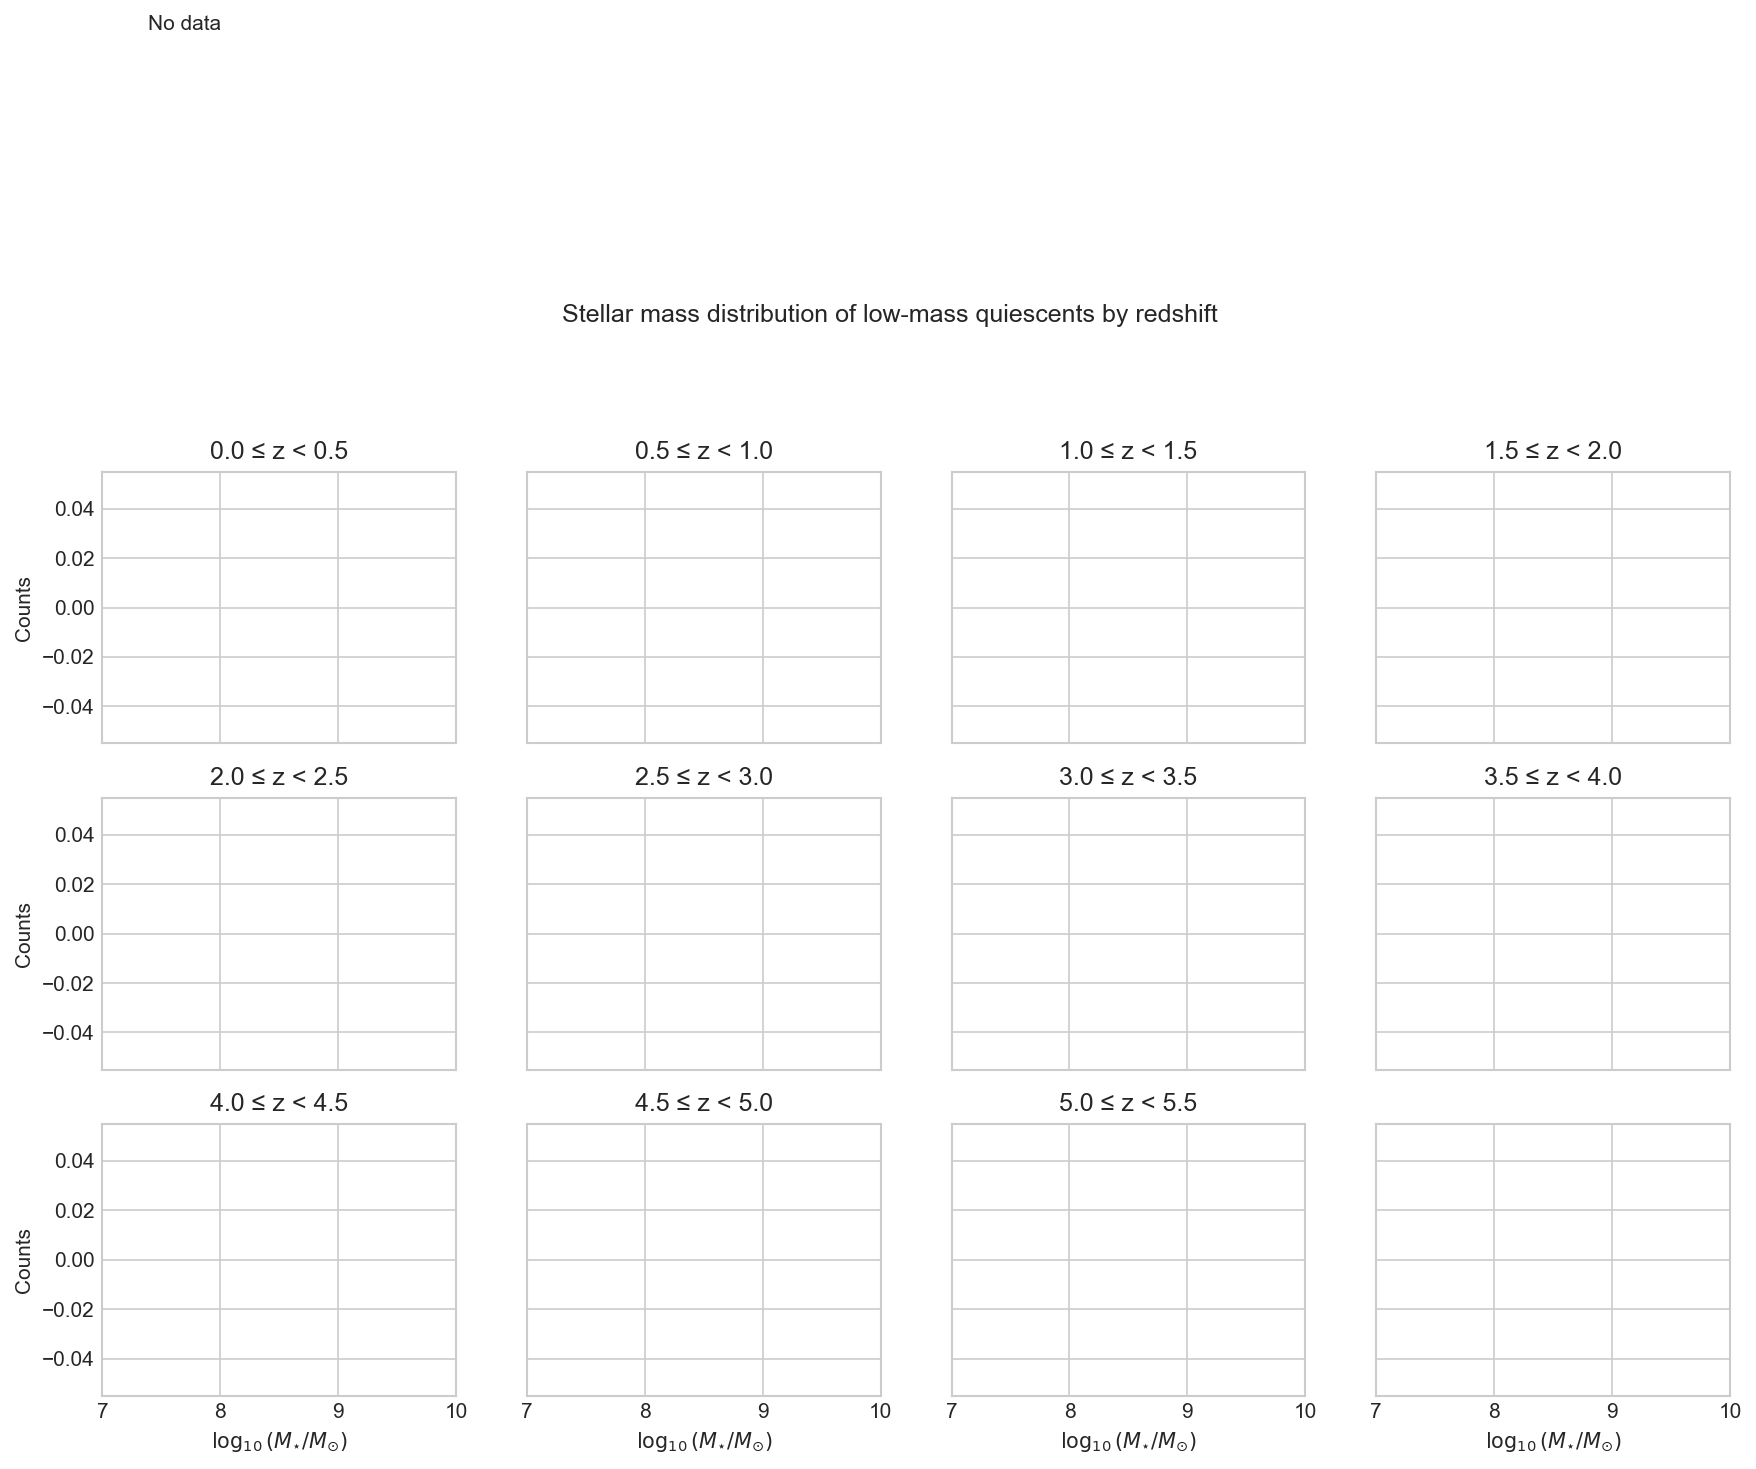

In [24]:
z_bins = np.arange(0.0, 5.6, 0.5)
z_labels = [f"{z_bins[i]:.1f} ≤ z < {z_bins[i+1]:.1f}" for i in range(len(z_bins)-1)]

fig, axes = plt.subplots(3, 4, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.ravel()

for idx, (z_min, z_max) in enumerate(zip(z_bins[:-1], z_bins[1:])):
    ax = axes[idx]
    bin_mask = final_mask & (catalog['zfinal'] >= z_min) & (catalog['zfinal'] < z_max)
    masses = mass_log[bin_mask]

    if masses.size == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
    else:
        ax.hist(masses, bins=np.linspace(7.0, 10.0, 16), color='steelblue', alpha=0.8)

    ax.set_title(z_labels[idx])
    ax.set_xlim(7.0, 10.0)

for ax in axes[8:]:
    ax.set_xlabel(r'$\log_{10}(M_{\star}/M_{\odot})$')
for ax in axes[::4]:
    ax.set_ylabel('Counts')

fig.suptitle('Stellar mass distribution of low-mass quiescents by redshift', y=1.02)
plt.tight_layout()
plt.show()

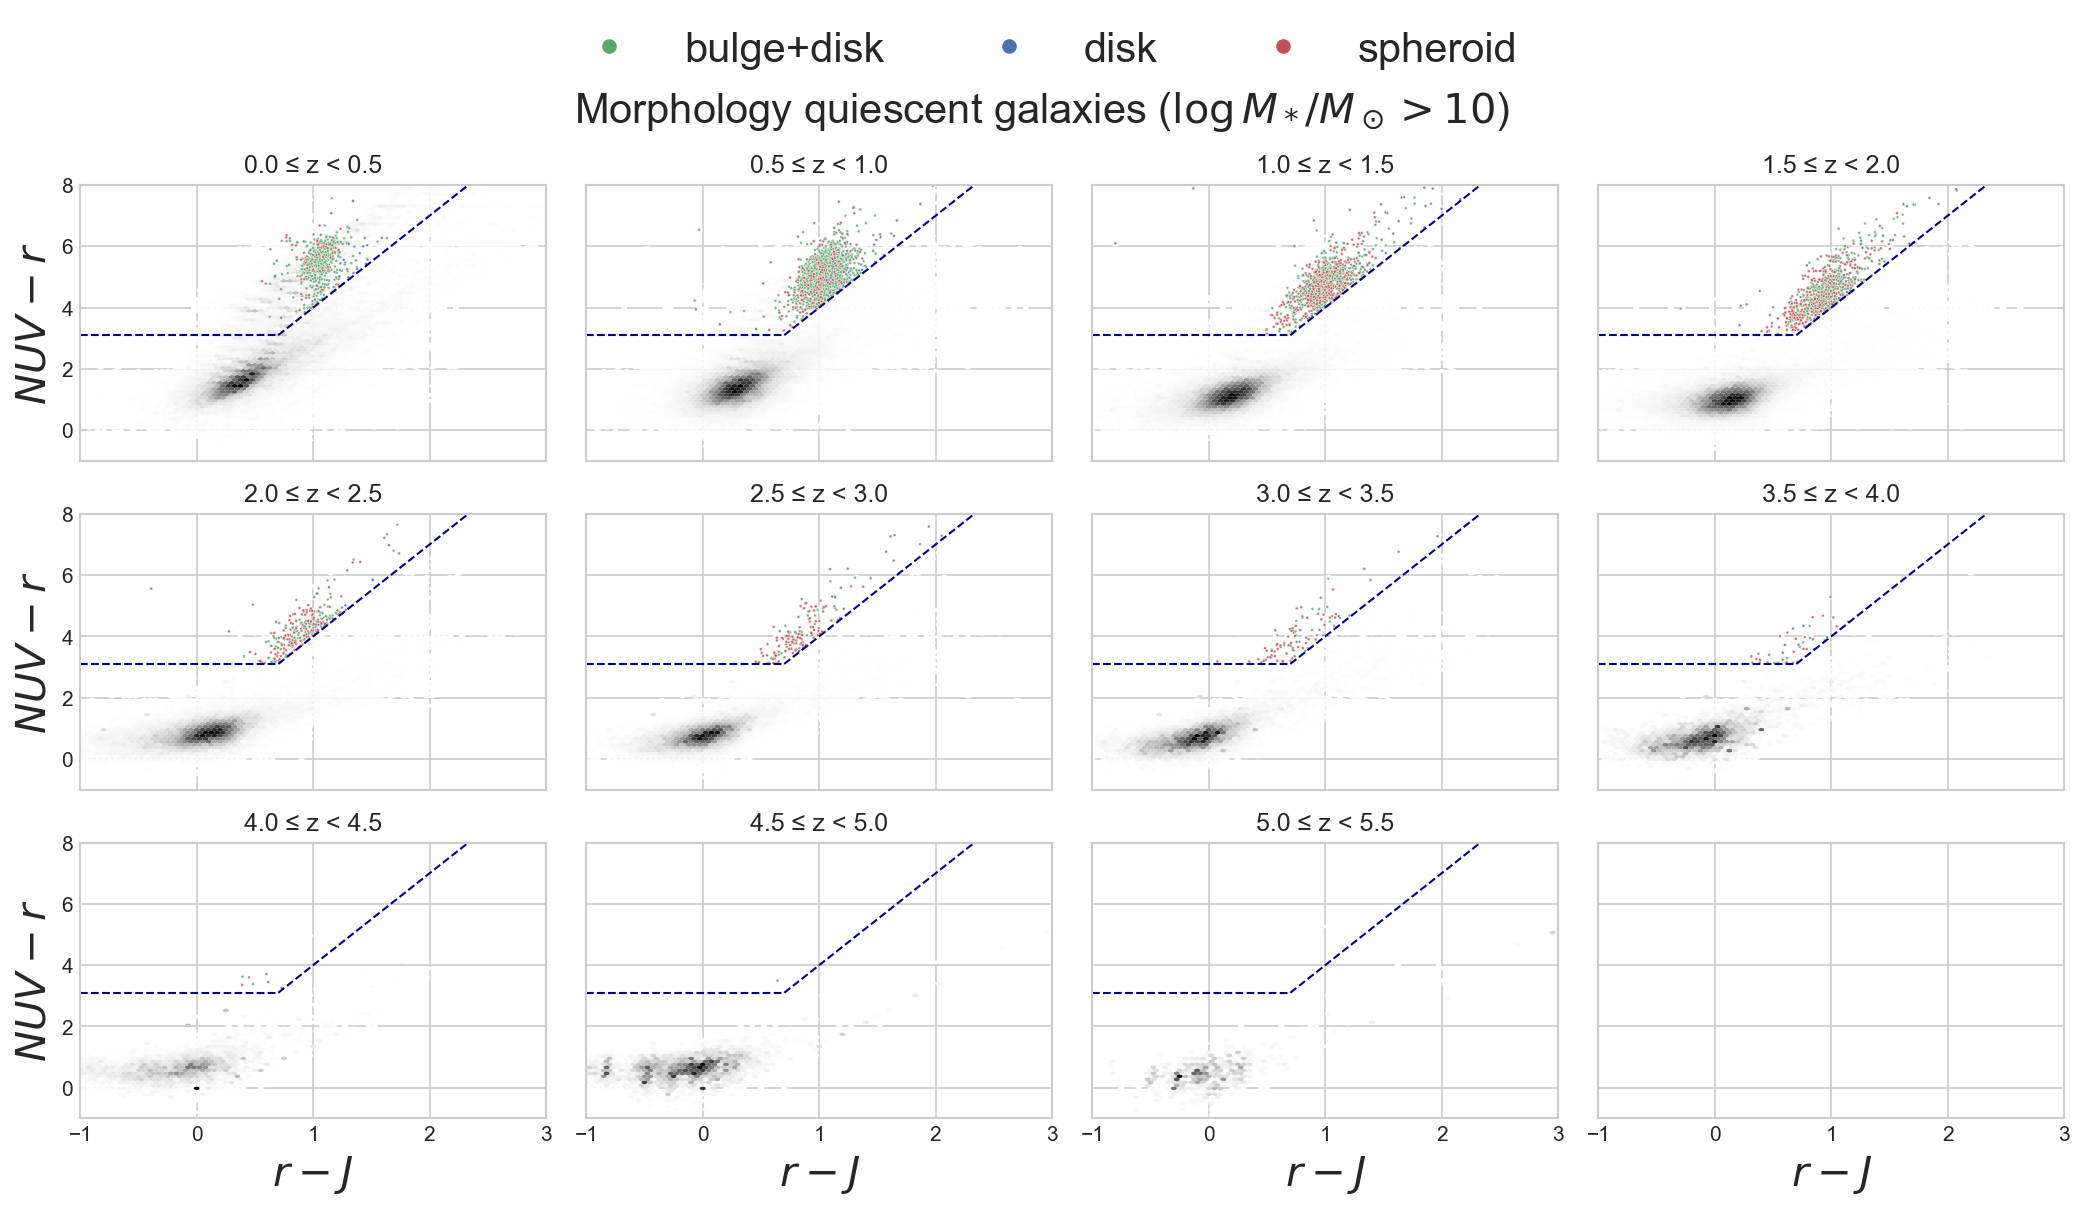

In [36]:
z_bins = np.arange(0.0, 5.6, 0.5)
z_labels = [f"{z_bins[i]:.1f} ≤ z < {z_bins[i+1]:.1f}" for i in range(len(z_bins) - 1)]

palette = {
    'disk': '#4C72B0',
    'bulge+disk': '#55A868',
    'spheroid': '#C44E52',
    'irregular': '#8172B2'
}

mapping = {
    'spheroid': 'spheroid',
    'irr-spheroid': 'spheroid',
    'disk': 'disk',
    'irr-disk': 'disk',
    'bulge+disk': 'bulge+disk',
    'irr-bulge+disk': 'bulge+disk',
    'irregular': 'irregular'
}

aggregated_classes = sorted(set(mapping.get(cls, cls) for cls in catalog['morph_unique_class'][final_mask]))

fig, axes = plt.subplots(3, 4, figsize=(14, 8), sharex=True, sharey=True)
axes = axes.ravel()

for idx, (z_min, z_max) in enumerate(zip(z_bins[:-1], z_bins[1:])):
    ax = axes[idx]
    bin_mask = clean_mask & (catalog['zfinal'] >= z_min) & (catalog['zfinal'] < z_max)
    quiescent_bin_mask = final_mask & (catalog['zfinal'] >= z_min) & (catalog['zfinal'] < z_max)

    if bin_mask.sum() == 0:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        ax.set_title(z_labels[idx])
        continue

    ax.hexbin(
        r_minus_j[bin_mask],
        nuv_minus_r[bin_mask],
        gridsize=80,
        extent=(-1, 3, -1, 8),
        cmap='Greys',
        mincnt=1,
        linewidths=0
    )

    classes = [mapping.get(cls, cls) for cls in catalog['morph_unique_class'][quiescent_bin_mask]]
    colors = [palette.get(cls, '#333333') for cls in classes]

    ax.scatter(
        r_minus_j[quiescent_bin_mask],
        nuv_minus_r[quiescent_bin_mask],
        s=2,
        c=colors,
        linewidths=0.25,
        edgecolor='white',
        alpha=0.8
    )

    ax.plot([-1, 0.7], [3.1, 3.1], color='navy', linestyle='--', linewidth=1.0)
    rj_line = np.linspace(0.7, 3.0, 100)
    ax.plot(rj_line, 3.0 * rj_line + 1.0, color='navy', linestyle='--', linewidth=1.0)

    ax.set_title(z_labels[idx])
    ax.set_xlim(-1, 3)
    ax.set_ylim(-1, 8)

for ax in axes[8:]:
    ax.set_xlabel(r'$r - J$',fontsize=20)
for ax in axes[::4]:
    ax.set_ylabel(r'$NUV - r$',fontsize=20)

handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=palette.get(cls, '#333333'),
                      markersize=8, label=cls) for cls in aggregated_classes]

fig.legend(handles=handles, loc='upper center', ncol=len(aggregated_classes), frameon=False, bbox_to_anchor=(0.5, 1.02),fontsize=20)
fig.suptitle('Morphology quiescent galaxies ($\log M_*/M_\odot>10$)', y=0.94,fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('plots/massive_Q_NUV_J.png')
plt.show()

## Morphology Fractions versus Local Density
Compare the consolidated morphology mix as a function of local overdensity quantiles in broad redshift slices.

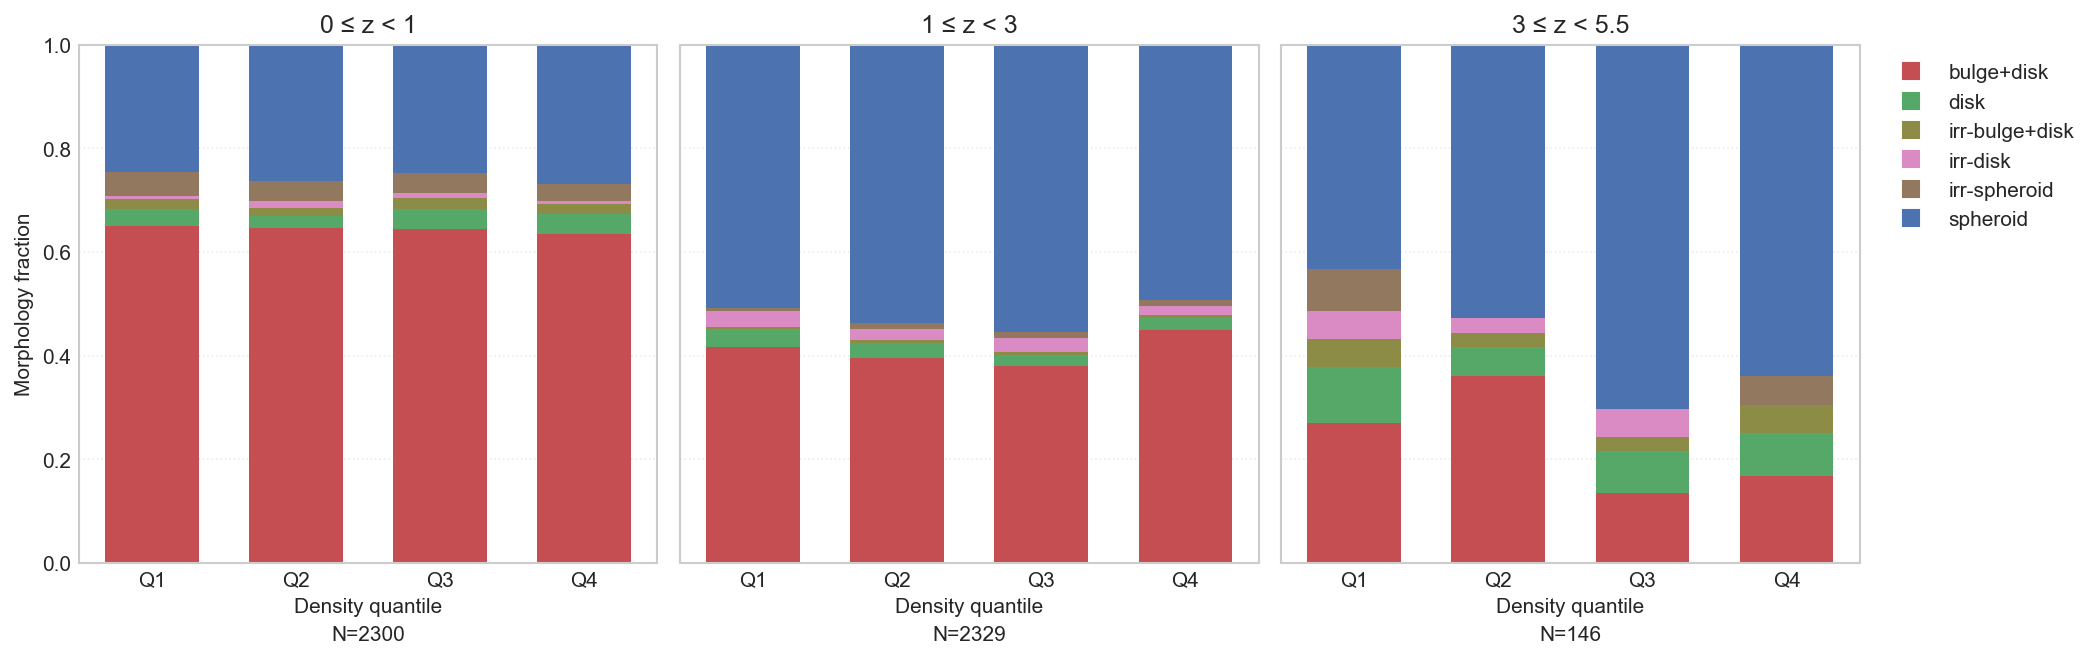

In [25]:
density_available_mask = final_mask & np.isfinite(catalog['overdensity'])

if density_available_mask.sum() == 0:
    print('No density information available for the selected sample.')
else:
    redshift_bins_density = [
        (0.0, 1.0, '0 ≤ z < 1'),
        (1.0, 3.0, '1 ≤ z < 3'),
        (3.0, 5.5, '3 ≤ z < 5.5')
    ]
    num_quantiles = 4
    quantile_labels = [f'Q{i+1}' for i in range(num_quantiles)]
    overall_classes = sorted(set(catalog['morph_unique_class'][density_available_mask]))
    class_palette = {
        'spheroid': '#4C72B0',
        'disk': '#55A868',
        'bulge+disk': '#C44E52',
        'irregular': '#8172B2',
        'irr-spheroid': '#937860',
        'irr-disk': '#DA8BC3',
        'irr-bulge+disk': '#8C8C47'
    }

    fig, axes = plt.subplots(1, len(redshift_bins_density), figsize=(16, 4.5), sharey=True)
    if len(redshift_bins_density) == 1:
        axes = [axes]

    positions = np.arange(num_quantiles)

    for ax, (z_min, z_max, title) in zip(axes, redshift_bins_density):
        bin_mask = density_available_mask & (catalog['zfinal'] >= z_min) & (catalog['zfinal'] < z_max)
        dens_values = np.asarray(catalog['overdensity'][bin_mask], dtype=float)
        morph_classes = np.asarray(catalog['morph_unique_class'][bin_mask])

        valid = np.isfinite(dens_values)
        dens_values = dens_values[valid]
        morph_classes = morph_classes[valid]

        if dens_values.size == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            ax.set_title(title)
            ax.set_xticks(positions)
            ax.set_xticklabels(quantile_labels)
            ax.set_ylim(0, 1)
            continue

        n = dens_values.size
        ranks = np.argsort(np.argsort(dens_values))
        quantile_indices = np.floor(ranks / n * num_quantiles).astype(int)
        quantile_indices[quantile_indices == num_quantiles] = num_quantiles - 1

        totals = np.array([np.count_nonzero(quantile_indices == q) for q in range(num_quantiles)], dtype=float)
        bottom = np.zeros(num_quantiles)

        for cls in overall_classes:
            counts = np.array([
                np.count_nonzero((quantile_indices == q) & (morph_classes == cls))
                for q in range(num_quantiles)
            ], dtype=float)
            fractions = np.zeros(num_quantiles, dtype=float)
            valid_totals = totals > 0
            fractions[valid_totals] = counts[valid_totals] / totals[valid_totals]
            ax.bar(
                positions,
                fractions,
                bottom=bottom,
                width=0.65,
                color=class_palette.get(cls, '#333333'),
                label=cls
            )
            bottom += fractions

        ax.set_ylim(0, 1)
        ax.set_xticks(positions)
        ax.set_xticklabels(quantile_labels)
        ax.set_xlabel('Density quantile')
        ax.set_title(title)
        ax.grid(axis='y', linestyle=':', alpha=0.4)
        sample_size = int(totals.sum())
        ax.text(0.5, -0.12, f'N={sample_size}', transform=ax.transAxes, ha='center', va='top')

    axes[0].set_ylabel('Morphology fraction')
    handles = []
    for cls in overall_classes:
        color = class_palette.get(cls, '#333333')
        handles.append(plt.Line2D([0], [0], marker='s', color=color, linestyle='', markersize=8, label=cls))
    axes[-1].legend(handles=handles, loc='upper left', bbox_to_anchor=(1.02, 1), frameon=False)
    plt.tight_layout(rect=[0, 0, 0.88, 1])
    plt.show()

### Aggregated Morphology Fractions
Group morphology classes by primary/secondary pairing so that, for instance, `disk` and `irr-disk` contribute to the same bar segment.

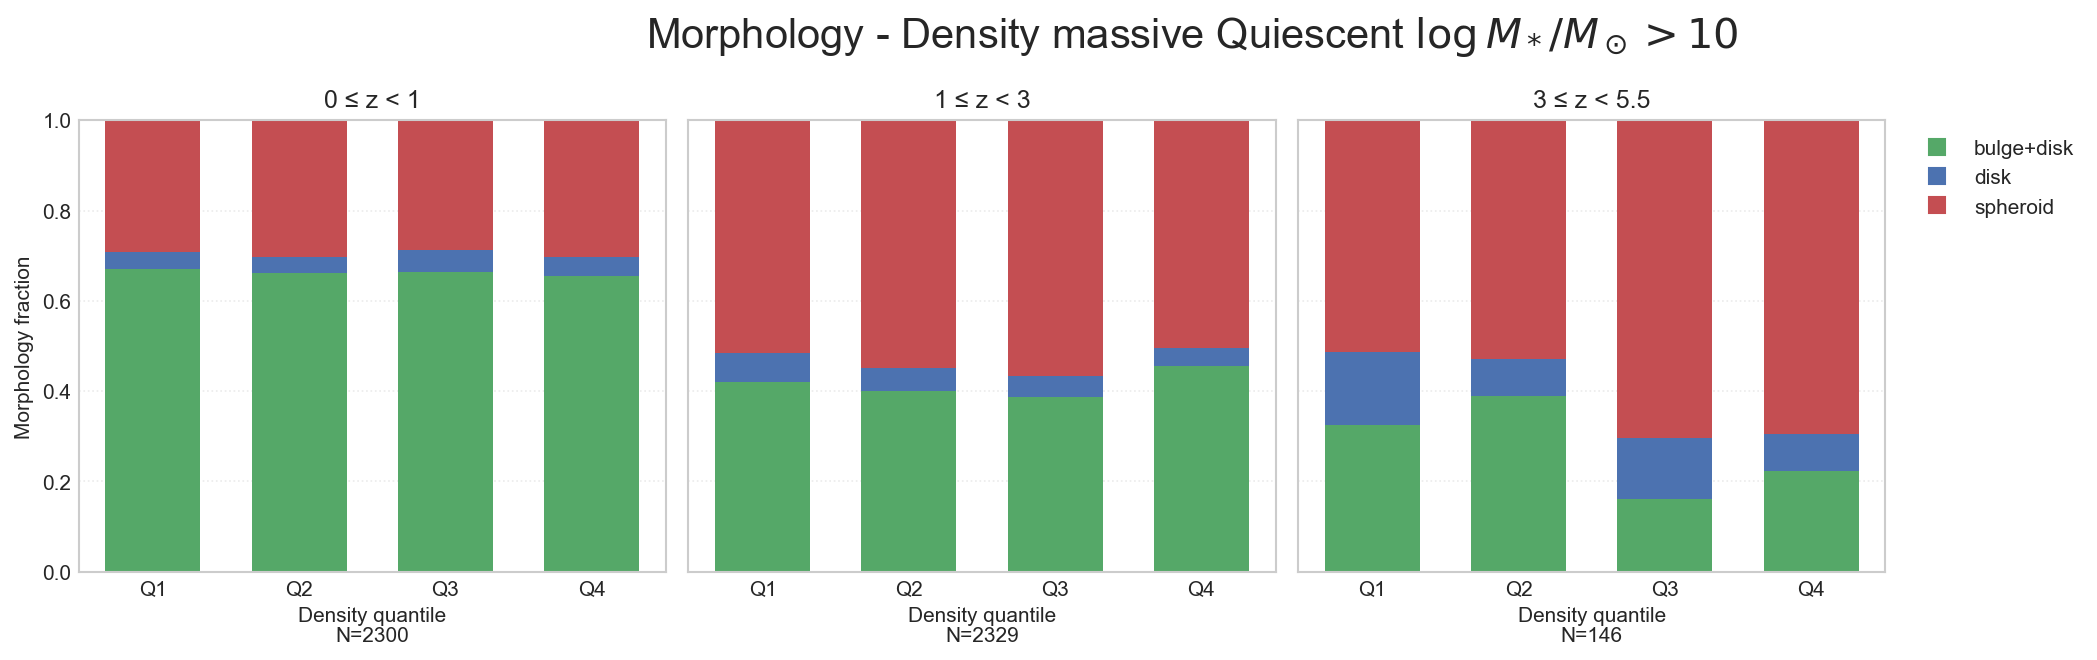

In [35]:
density_available_mask = final_mask & np.isfinite(catalog['overdensity'])

if density_available_mask.sum() == 0:
    print('No density information available for the selected sample.')
else:
    redshift_bins_density = [
        (0.0, 1.0, '0 ≤ z < 1'),
        (1.0, 3.0, '1 ≤ z < 3'),
        (3.0, 5.5, '3 ≤ z < 5.5')
    ]
    num_quantiles = 4
    quantile_labels = [f'Q{i+1}' for i in range(num_quantiles)]

    mapping = {
        'spheroid': 'spheroid',
        'irr-spheroid': 'spheroid',
        'disk': 'disk',
        'irr-disk': 'disk',
        'bulge+disk': 'bulge+disk',
        'irr-bulge+disk': 'bulge+disk',
        'irregular': 'irregular'
    }

    aggregated_classes = sorted(set(mapping.get(cls, cls) for cls in catalog['morph_unique_class'][density_available_mask]))

    palette = {
        'disk': '#4C72B0',
        'bulge+disk': '#55A868',
        'spheroid': '#C44E52',
        'irregular': '#8172B2'
    }

    fig, axes = plt.subplots(1, len(redshift_bins_density), figsize=(16, 4.5), sharey=True)
    if len(redshift_bins_density) == 1:
        axes = [axes]

    positions = np.arange(num_quantiles)

    for ax, (z_min, z_max, title) in zip(axes, redshift_bins_density):
        bin_mask = density_available_mask & (catalog['zfinal'] >= z_min) & (catalog['zfinal'] < z_max)
        dens_values = np.asarray(catalog['overdensity'][bin_mask], dtype=float)
        morph_classes = np.asarray(catalog['morph_unique_class'][bin_mask])

        valid = np.isfinite(dens_values)
        dens_values = dens_values[valid]
        morph_classes = morph_classes[valid]

        if dens_values.size == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            ax.set_title(title)
            ax.set_xticks(positions)
            ax.set_xticklabels(quantile_labels)
            ax.set_ylim(0, 1)
            continue

        grouped = np.array([mapping.get(cls, cls) for cls in morph_classes])

        n = dens_values.size
        ranks = np.argsort(np.argsort(dens_values))
        quantile_indices = np.floor(ranks / n * num_quantiles).astype(int)
        quantile_indices[quantile_indices == num_quantiles] = num_quantiles - 1

        totals = np.array([np.count_nonzero(quantile_indices == q) for q in range(num_quantiles)], dtype=float)
        bottom = np.zeros(num_quantiles)

        for cls in aggregated_classes:
            counts = np.array([
                np.count_nonzero((quantile_indices == q) & (grouped == cls))
                for q in range(num_quantiles)
            ], dtype=float)
            fractions = np.zeros(num_quantiles, dtype=float)
            valid_totals = totals > 0
            fractions[valid_totals] = counts[valid_totals] / totals[valid_totals]
            ax.bar(
                positions,
                fractions,
                bottom=bottom,
                width=0.65,
                color=palette.get(cls, '#333333'),
                label=cls
            )
            bottom += fractions

        ax.set_ylim(0, 1)
        ax.set_xticks(positions)
        ax.set_xticklabels(quantile_labels)
        ax.set_xlabel('Density quantile')
        ax.set_title(title)
        ax.grid(axis='y', linestyle=':', alpha=0.4)
        sample_size = int(totals.sum())
        ax.text(0.5, -0.12, f'N={sample_size}', transform=ax.transAxes, ha='center', va='top')

    axes[0].set_ylabel('Morphology fraction')
    handles = []
    for cls in aggregated_classes:
        color = palette.get(cls, '#333333')
        handles.append(plt.Line2D([0], [0], marker='s', color=color, linestyle='', markersize=8, label=cls))
    axes[-1].legend(handles=handles, loc='upper left', bbox_to_anchor=(1.02, 1), frameon=False)
    fig.suptitle('Morphology - Density massive Quiescent $\log M_*/M_\odot>10$', y=0.98,fontsize=20)
    plt.tight_layout(rect=[0, 0, 0.88, 1])
    plt.savefig('plots/morph_density_massiveQ.png')
    plt.show()

## Mean SFHs by Morphology, Redshift, and Density
Average the CIGALE star-formation histories in broad redshift bins and the lowest/highest density quartiles for each aggregated morphology class.

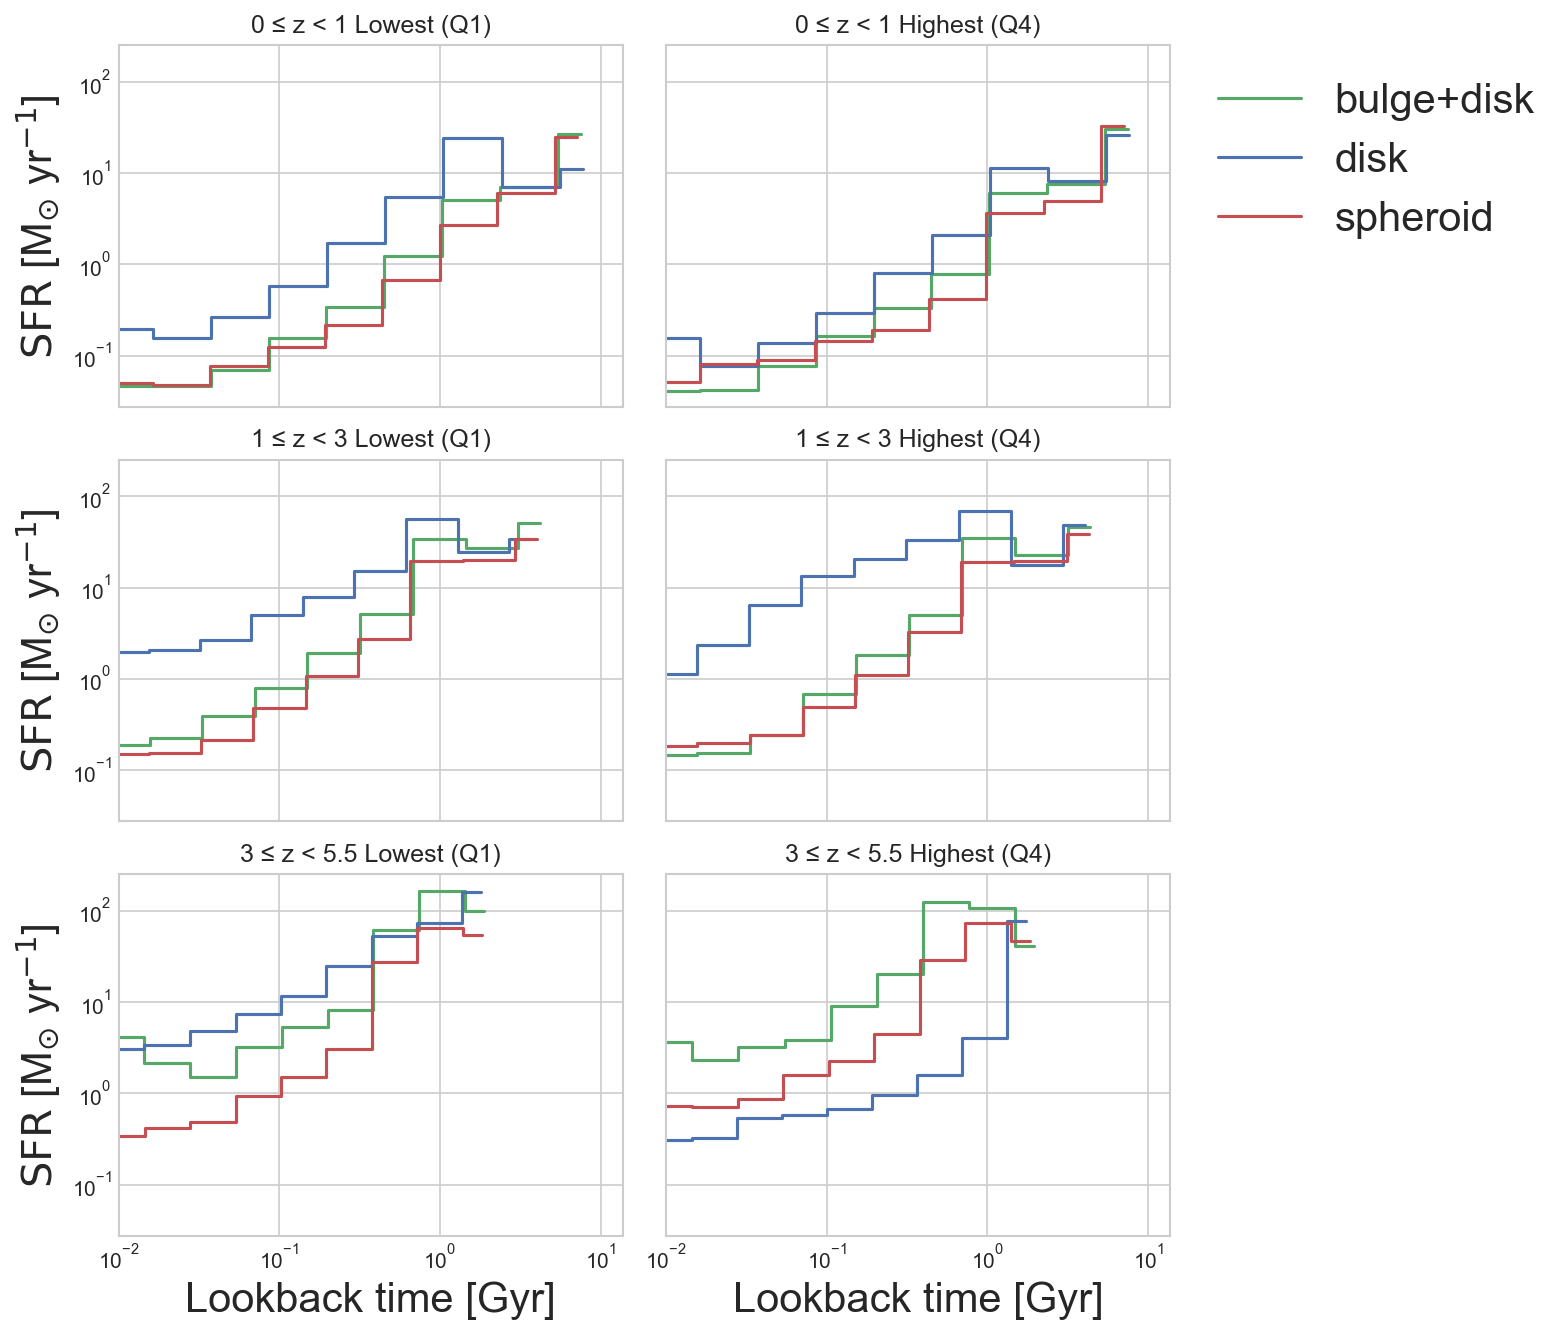

In [31]:
density_available_mask = final_mask & np.isfinite(catalog['overdensity'])

if density_available_mask.sum() == 0:
    print('No density information available for the selected sample.')
else:
    redshift_bins_density = [
        (0.0, 1.0, '0 ≤ z < 1'),
        (1.0, 3.0, '1 ≤ z < 3'),
        (3.0, 5.5, '3 ≤ z < 5.5')
    ]
    num_quantiles = 4
    density_quantiles = [('Lowest (Q1)', 0), ('Highest (Q4)', num_quantiles - 1)]

    mapping = {
        'spheroid': 'spheroid',
        'irr-spheroid': 'spheroid',
        'disk': 'disk',
        'irr-disk': 'disk',
        'bulge+disk': 'bulge+disk',
        'irr-bulge+disk': 'bulge+disk',
        'irregular': 'irregular'
    }

    aggregated_labels = np.array([mapping.get(cls, cls) for cls in catalog['morph_unique_class']])
    aggregated_classes = sorted(set(aggregated_labels[density_available_mask]))

    palette = {
        'disk': '#4C72B0',
        'bulge+disk': '#55A868',
        'spheroid': '#C44E52',
        'irregular': '#8172B2'
    }

    time_array = np.column_stack([catalog[col] for col in sfh_time_cols]) / 1e3  # convert to Gyr
    sfr_fraction_array = np.column_stack([catalog[col] for col in sfh_sfr_cols])
    sfh_integrated = np.asarray(catalog['sfh_integrated'], dtype=float)
    sfr_array = sfr_fraction_array * sfh_integrated[:, None]

    valid_time = time_array[np.isfinite(time_array)]
    valid_sfr = sfr_array[np.isfinite(sfr_array)]
    if valid_time.size == 0 or valid_sfr.size == 0:
        print('SFH information missing for all selected sources.')
    else:
        time_min = max(valid_time.min(), 1e-3)
        time_max = valid_time.max()

        fig, axes = plt.subplots(len(redshift_bins_density), len(density_quantiles), figsize=(12, 9), sharex=True, sharey=True)
        axes = np.atleast_2d(axes)

        for i, (z_min, z_max, title) in enumerate(redshift_bins_density):
            bin_mask = density_available_mask & (catalog['zfinal'] >= z_min) & (catalog['zfinal'] < z_max)
            if not bin_mask.any():
                for ax in axes[i]:
                    ax.text(0.5, 0.5, 'No data', ha='center', va='center')
                    ax.set_title(f'{title}(no sample)')
                continue

            bin_indices = np.where(bin_mask)[0]
            dens_values = np.asarray(catalog['overdensity'][bin_mask], dtype=float)
            valid = np.isfinite(dens_values)
            bin_indices = bin_indices[valid]
            dens_values = dens_values[valid]

            if dens_values.size == 0:
                for ax in axes[i]:
                    ax.text(0.5, 0.5, 'No density', ha='center', va='center')
                    ax.set_title(f'{title}(no density)')
                continue

            ranks = np.argsort(np.argsort(dens_values))
            quantile_indices = np.floor(ranks / dens_values.size * num_quantiles).astype(int)
            quantile_indices[quantile_indices == num_quantiles] = num_quantiles - 1

            for j, (label, q_idx) in enumerate(density_quantiles):
                ax = axes[i, j]
                selected_indices = bin_indices[quantile_indices == q_idx]
                if selected_indices.size == 0:
                    ax.text(0.5, 0.5, 'No data', ha='center', va='center')
                    ax.set_title(f'{title}{label}')
                    continue

                lines_drawn = 0
                for cls in aggregated_classes:
                    class_mask = (aggregated_labels == cls)
                    group_mask = class_mask.copy()
                    group_mask[:] = False
                    group_mask[selected_indices] = True
                    group_mask &= class_mask

                    sfh_subset = sfr_array[group_mask]
                    time_subset = time_array[group_mask]

                    if sfh_subset.size == 0:
                        continue

                    finite_rows = (
                        np.isfinite(sfh_subset).all(axis=1) &
                        np.isfinite(time_subset).all(axis=1)
                    )
                    if finite_rows.sum() == 0:
                        continue

                    mean_time = np.nanmean(time_subset[finite_rows], axis=0)
                    mean_sfr = np.nanmean(sfh_subset[finite_rows], axis=0)

                    ax.step(mean_time, mean_sfr, where='mid', color=palette.get(cls, '#333333'), label=cls)
                    lines_drawn += 1

                if lines_drawn == 0:
                    ax.text(0.5, 0.5, 'No SFH data', ha='center', va='center')

                ax.set_title(f'{title} {label}')
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.set_xlim(time_min, time_max)

        for ax in axes[:, 0]:
            ax.set_ylabel(r'$\mathrm{SFR}$ [M$_{\odot}$ yr$^{-1}$]',fontsize=20)
        for ax in axes[-1, :]:
            ax.set_xlabel('Lookback time [Gyr]',fontsize=20)

        handles = [plt.Line2D([0], [0], color=palette.get(cls, '#333333'), label=cls) for cls in aggregated_classes]
        axes[0, -1].legend(handles=handles, loc='upper left', bbox_to_anchor=(1.02, 1), frameon=False,fontsize=20)

        plt.tight_layout(rect=[0, 0, 0.88, 1])
        plt.savefig('plots/SFH_CIGALE_morph_massiveQ.png')
        plt.show()

## Visualise the Color-Color Selection
Show the NUV-r versus r-J diagram, highlight the quiescent boundary, and overlay the selected low-mass quiescent galaxies.

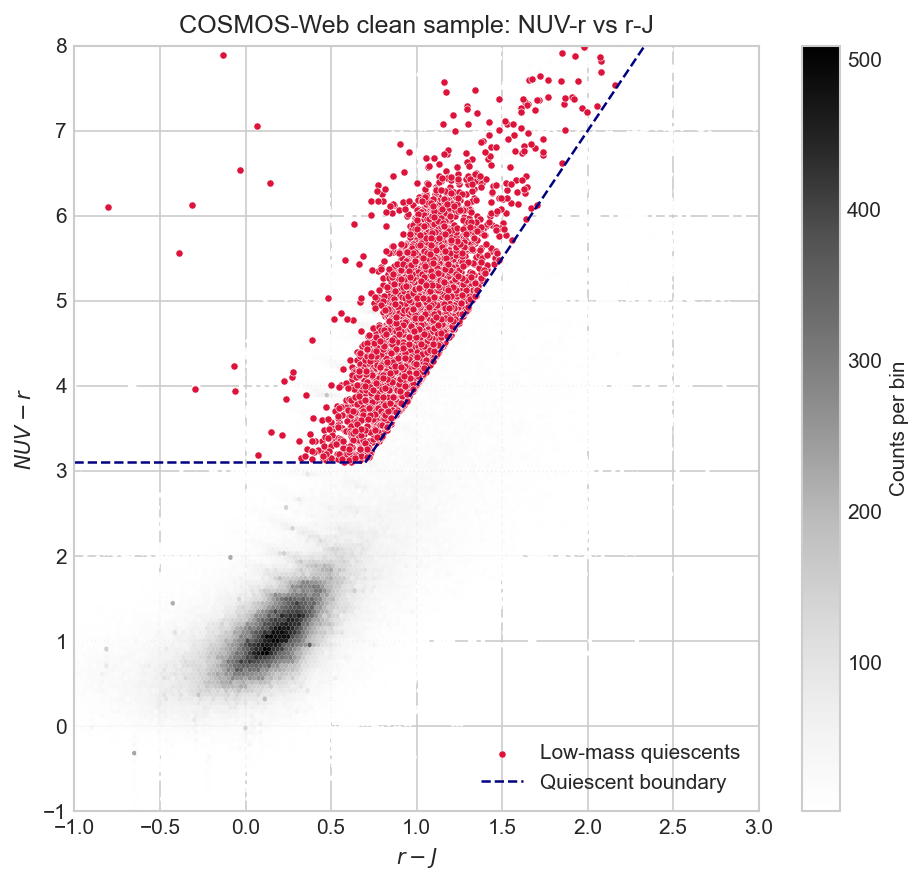

In [28]:
fig, ax = plt.subplots(figsize=(6.4, 6.0))

hb = ax.hexbin(
    r_minus_j[clean_mask],
    nuv_minus_r[clean_mask],
    gridsize=160,
    extent=(-1, 3, -1, 8),
    cmap='Greys',
    mincnt=1,
    linewidths=0
)
cb = fig.colorbar(hb, ax=ax, label='Counts per bin')

ax.scatter(
    r_minus_j[final_mask],
    nuv_minus_r[final_mask],
    s=12,
    c='crimson',
    edgecolor='white',
    linewidths=0.3,
    label='Low-mass quiescents'
)

# Quiescent selection boundaries
ax.plot([-1, 0.7], [3.1, 3.1], color='navy', linestyle='--', linewidth=1.2, label='Quiescent boundary')
rj_line = np.linspace(0.7, 3.0, 200)
ax.plot(rj_line, 3.0 * rj_line + 1.0, color='navy', linestyle='--', linewidth=1.2)

ax.set_xlim(-1, 3)
ax.set_ylim(-1, 8)
ax.set_xlabel(r'$r - J$')
ax.set_ylabel(r'$NUV - r$')
ax.legend(loc='lower right', frameon=False)
ax.set_title('COSMOS-Web clean sample: NUV-r vs r-J')
plt.tight_layout()
plt.show()

## Preview the Selected Sample
Display a few key columns for the quiescent subset; convert to pandas for easier viewing if desired.

In [29]:
display_columns = ['id', 'zfinal', 'mass_med', 'ssfr_med', 'nuv_minus_r', 'r_minus_j']
quiescent_sample[display_columns][:10]

id,zfinal,mass_med,ssfr_med,nuv_minus_r,r_minus_j
int64,float64,float64,float64,float64,float64
152,0.9703,10.5366,-13.36985,4.9656400000000005,0.9866600000000005
360,0.35,10.65018,-12.60101,5.89043,1.0774100000000004
361,0.3499,10.79992,-18.99773,5.886680000000002,1.0463500000000003
506,1.1914,10.59761,-11.60547,4.990299999999998,1.0653700000000015
644,0.8816,10.10223,-13.34045,4.969299999999999,1.0458300000000023
759,0.3296,10.34985,-11.60097,5.465890000000002,1.2747600000000006
780,0.3532,10.29331,-22.81019,5.562309999999998,0.9936100000000003
884,0.3575,10.8482,-15.32435,6.342649999999999,1.1934400000000025
891,0.9434,10.44992,-11.59711,4.699259999999999,0.9973400000000012
